In [26]:
import numpy as np
#import pyfits as fits
import math
from astropy import wcs
from astropy.io import fits
from astropy.io import ascii
from scipy.interpolate import griddata
from scipy import stats
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
from astropy.table import Table, Column

%matplotlib inline

# %&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&
# CGS PHYSICAL CONSTANTS
# %&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&

c = 2.99792458e10       # speed of light CGS
h = 6.6260755e-27       # Planck's constant CGS
g = 6.67259e-8          # Grav const CGS
kb = 1.380658e-16       # Boltzmann's const CGS
a = 7.56591e-15         # Radiation constant CGS
sb = 5.67051e-5         # sigma (stefan-boltzmann const) CGS
qe =  4.803206e-10      # Charge of electron CGS
ev =  1.60217733e-12    # Electron volt CGS
na =  6.0221367e23      # Avagadro's Number
me =  9.1093897e-28     # electron mass CGS
mp =  1.6726231e-24     # proton mass CGS
mn = 1.674929e-24       # neutron mass CGS
mh = 1.673534e-24       # hydrogen mass CGS
amu =  1.6605402e-24    # atomic mass unit CGS
pi = 3.1415926535897932384626433832795028841971693993
# %&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&
# ASTRONOMICAL CONSTANTS
# %&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&

# GENERAL
au = 1.496e13           # astronomical unit CGS
pc = 3.0857e18          # parsec CGS
yr = 3.155815e7         # sidereal year CGS
ms = 1.98900e+33        # solar mass CGS
rs = 6.9599e10          # sun's radius CGS
ls = 3.839e33           # sun's luminosity CGS
mm = 7.35000e+25        # moon mass CGS
mer = 5.97400e+27       # earth mass CGS
rer = 6.378e8           # earth's radius CGS
medd = 3.60271e+34      # Eddington mass CGS

# RADIO SPECIFIC
jy = 1.e-23                  # Jansky CGS
restfreq_hi = 1420405751.786 # 21cm transition (Hz)
restfreq_co = 115271201800.  # CO J=1-0 (Hz)
cm2perkkms_hi = 1.823e18     # HI column per intensity (thin)

In [27]:
pa=(90.0-29.5)*3.14159/180.0
#pa=(45.0)*3.14159/180.0
inc=45.0*3.14159/180.0

pa = 0.
inc= 0.
dist=230.
# FUNCTION
def icrs_hr(icrs):
    tmp0 = float(icrs[0])
    tmp01 = tmp0
    if tmp01 < 0:
        tmp0 = abs(tmp0)
    tmp1 = abs(float(icrs[1])/60.)
    tmp2 = abs(float(icrs[2])/3600.)
    icrs = tmp0 + tmp1 + tmp2
    if tmp01 < 0:
        icrs = icrs * -1.
    return icrs

# must be run on deprojected data

imagename='L1448IRS3B_C17O_image_taper1500k.deproj_total.image.integrated.fits'
_end_='gdr_c17o_cont'
rms=4.34E-4
hdu = fits.open(imagename)
image = np.transpose(np.copy(hdu[0].data))
image=np.copy(hdu[0].data)

# PUT IN DEGREES or ICRS
ra_orig='03 25 36.297'
dec_orig='30 45 14.502'
while True:
    try:
        ra_fin = float(ra_orig)
        dec_fin = float(dec_orig)
    except ValueError:
        try:
            ra_fin = ra_orig.split(':')
            dec_fin = dec_orig.split(':')
            if len(ra_fin) == 1:
                ra_fin =  ra_orig.split(' ')            
            if len(dec_fin) == 1:
                dec_fin =  dec_orig.split(' ')
            if ((len(dec_fin) == 3) and (len(ra_fin) == 3)):
                ra_fin=icrs_hr(ra_fin)*15.
                dec_fin=icrs_hr(dec_fin)
                break
            else:
                continue
        except ValueError:
            input('Error: Press [RET] to continue.')
            continue
        continue
if (type(ra_fin) is float) and (type(dec_fin) is float):
    ra=ra_fin
    dec=dec_fin

# read in file
header= hdu[0].header
w = wcs.WCS(hdu[0].header)
pixscaledeg=header['CDELT2']
pixscale=header['CDELT2']*3600
bmaj=header['BMAJ']
bmin=header['BMIN']
npix=header['NAXIS1']
freq=header['CRVAL3']

print('bmaj: ',bmaj)
print('bmin: ',bmin)
print('npix: ',npix)

# define beam areas
omega=(pi*bmaj*bmin)*(pi/180.0)**2
beamarea=(omega)/(4.0*math.log(2.0))
pixelarea=(230.0 *pixscale*au)**2
print("Pixel scale (cell size): ", pixscale)
print('Frequency (Hz): ', freq)
lamb=c/freq
print('Wavelength (cm): ',lamb)
print('Beam area (rad)', beamarea)
print('Proj Pixel area ', pixelarea)
tpixelarea=(pixscaledeg*pi/180.0)**2
pixelsperbeam=(beamarea/tpixelarea)
print('Pixel area ', tpixelarea)

print('Pixels per beam area', pixelsperbeam)
image=image[::-1][::-1][:][:]#*jybm2jy
print('RA DEC: ',ra,dec)

avgbeam=(bmaj+bmin)/2.0*3600.0
print('Average Beam: ', avgbeam,avgbeam/pixscale)
aperturebase=avgbeam/pixscale/2.0

world=np.array([[ra,dec,0,0]  ])
pix=w.wcs_world2pix(world, 0)
print('Pixels: ',pix)
xcen=pix[0][0]
ycen=pix[0][1]
apertures=np.arange(1.0,40.0, dtype=np.float)*aperturebase # edit this to increase mask size
print("Apertures: ",apertures)
#!print('Length Apertures: ',len(apertures))

# newgridding
xgrid_off=np.arange(npix,dtype=np.float)-xcen
ygrid_off=np.arange(npix,dtype=np.float)-ycen

ygrid_proj=ygrid_off/np.cos(inc)

xgrid,ygrid=np.meshgrid(xgrid_off,ygrid_proj)

r = np.sqrt(xgrid**2 + (ygrid)**2)
mask1 = r < apertures[5]
mask2 = r > apertures[4] 
mask=mask1*mask2

bmaj:  7.500263551871e-05
bmin:  5.003065698677e-05
npix:  2048
Pixel scale (cell size):  0.0200000000000016
Frequency (Hz):  337066831576.0
Wavelength (cm):  0.08894154805985544
Beam area (rad) 1.295185237766012e-12
Proj Pixel area  4.735641856000758e+27
Pixel area  9.401772215640656e-15
Pixels per beam area 137.7596912645214
RA DEC:  51.4012375 30.754028333333334
Average Beam:  0.225059926509864 11.2529963254923
Pixels:  [[  1.07814034e+03   1.01360008e+03   2.72538044e+06  -1.00000000e+00]]
Apertures:  [   5.62649816   11.25299633   16.87949449   22.50599265   28.13249081
   33.75898898   39.38548714   45.0119853    50.63848346   56.26498163
   61.89147979   67.51797795   73.14447612   78.77097428   84.39747244
   90.0239706    95.65046877  101.27696693  106.90346509  112.52996325
  118.15646142  123.78295958  129.40945774  135.03595591  140.66245407
  146.28895223  151.91545039  157.54194856  163.16844672  168.79494488
  174.42144305  180.04794121  185.67443937  191.30093753  196.9

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

In [28]:
xgrid_rot= (xgrid * np.cos(pa) - ygrid * np.sin(pa)) # disk major axis
ygrid_rot= (xgrid * np.sin(pa) + ygrid * np.cos(pa)) # disk minor axis

r = np.sqrt(xgrid_rot**2 + (ygrid_rot/np.cos(inc))**2)
mask1 = r > apertures[5]
mask2 = r < apertures[6]
mask=mask1*mask2

mask1 = r > apertures[5]
mask2 = r < apertures[6]
mask=mask1*mask2
print(mask[1024][:])
print(image.shape)
print(mask.shape)
maskedimage=np.ma.MaskedArray(image[0,0,:,:], mask=mask)
print(maskedimage.shape)

[False False False ..., False False False]
(1, 1, 2048, 2048)
(2048, 2048)
(2048, 2048)


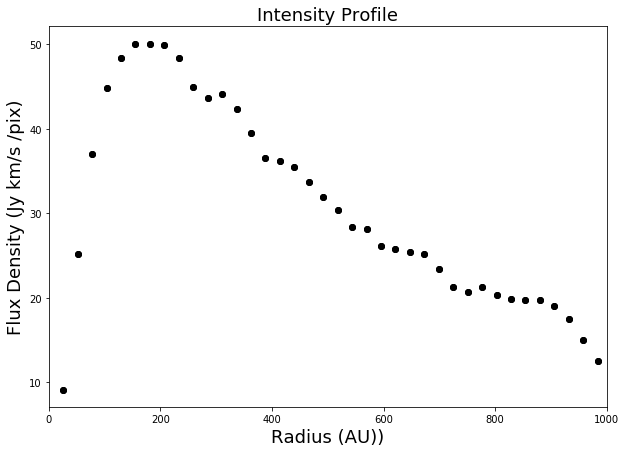

In [29]:
aper_fluxes=np.zeros(len(apertures))
error_aper_fluxes=np.zeros(len(apertures))
diff_aper_fluxes=np.zeros(len(apertures))
error_diff_aper_fluxes=np.zeros(len(apertures))
diff_area=np.zeros(len(apertures))
pix_array=np.zeros(len(apertures))


# for finding area of annulus (diff_area), flux per annulus (diff_aper_fluxes)
#print('apertures, aper_fluxes,error_aper_fluxes, diff_aper_fluxes,error_diff_aper_fluxes,npixels')
for i in range(len(apertures)):
    if i == 0:
        mask = r > apertures[0]
        maskinverse=r < apertures[0]
        maskinverse=~mask
        maskedimage=np.ma.MaskedArray(image[0,0,:,:], mask=mask)
        npixels=np.sum(~mask)
        pix_array[i]=npixels
    elif i > 0:  
        mask1 = r > apertures[i-1]
        mask2 = r <= apertures[i]
        mask = mask1*mask2
        maskinverse=~mask
        maskedimage=np.ma.MaskedArray(image[0,0,:,:], mask=~mask)
        npixels=np.sum(mask)
        pix_array[i]=npixels

    aper_fluxes[i]=np.sum(maskedimage)

    error_aper_fluxes[i]=npixels/pixelsperbeam*rms
    if i == 0:
        diff_aper_fluxes[i]=aper_fluxes[i].copy()
        error_diff_aper_fluxes[i]=error_aper_fluxes[i].copy()
        diff_area[i]=(apertures[i]*pixscale*230.0)**2*3.14159
    elif i > 0:
        diff_aper_fluxes[i]=aper_fluxes[i].copy()
        error_diff_aper_fluxes[i]=error_aper_fluxes[i].copy()
        diff_area[i]=(apertures[i]*pixscale*230.0)**2*3.14159 -(apertures[i-1]*pixscale*230.0)**2*3.14159

#print(len(diff_aper_fluxes))
for _NUM_,_VAL_ in enumerate(diff_aper_fluxes):
    if _NUM_ == 0:
        aper_fluxes[_NUM_]=diff_aper_fluxes[_NUM_]
    else:
        aper_fluxes[_NUM_]=sum(diff_aper_fluxes[0:_NUM_])
    #print(apertures[_NUM_], aper_fluxes[_NUM_],error_aper_fluxes[_NUM_], diff_aper_fluxes[_NUM_],error_diff_aper_fluxes[_NUM_],pix_array[_NUM_])
    
fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_xlim(0,1000.0)
#ax.set_ylim(-0.001,0.01)

radii=apertures*pixscale*230.0
#print(radii)
lin1=ax.plot(radii,diff_aper_fluxes,marker='o',color='black',linestyle='none')
lin1err=ax.errorbar(radii,diff_aper_fluxes, yerr=error_diff_aper_fluxes, fmt='o',color='black')

ax.set_title('Intensity Profile', fontsize=18)
ax.set_ylabel('Flux Density (Jy km/s /pix)', fontsize=18)
ax.set_xlabel('Radius (AU))', fontsize=18)

In [32]:
radii=apertures*pixscale*230.0
L_system=8.3
teq_at_1AU=(L_system*ls/(16.0*sb*pi*(au)**2))**0.25 # assuming thin disk
print('teq_at_1AU: ',teq_at_1AU)
temp=(radii/1.0)**(-0.5)*teq_at_1AU  # assuming thin disk in which thin disk temp > effective temp

modeltemp=ascii.read('TvsR.dat',names=['R', 'T'])

modeltemp['R']=modeltemp['R']/1.496e13
#print(modeltemp
newtemp=griddata(modeltemp['R'],modeltemp['T'],radii,method='linear',fill_value=-99.0)
ind = (modeltemp['R'] > 75.0).nonzero()

#print(modeltemp['R'][ind])

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(modeltemp['R'][ind]),np.log10(modeltemp['T'][ind]))
#print('Fit params',slope, intercept, r_value, p_value, std_err)
newtempextrap=(radii/radii[6])**(slope)*newtemp[6]
ind = (newtemp == -99.0).nonzero()
#print('ind: ',ind)
newtemp[ind]=newtempextrap[ind]
radii=apertures*pixscale*230.0

def emissive_mass(flux=None,freq=None,lam=None,distance=None,Tex=None):    
    # apply Goldsmith and Langer 1999 to convert each pixel into a mass
    # beam area
    #The below math does this: Jy*km/s / beam to Jy km/s / area to K*km/s / area  
    #  to num_mol/area to num_mol_h2/area to num_mol_h2/pix
    
    theta = 0.27*0.19            # arcsec^2
    theta = theta*np.pi * (1./(60.*60.))**2 * (np.pi/180.)**2# square degrees
    jybm2jy=(lam/10)**2*jy/(2.*theta*kb)*4.*0.693
    w=flux*jybm2jy   #  Jy*km/s / beam to Jy*km/s /area to K km/s / area
    #print('conv: ',jybm2jy)
    
    # Partition Function
    a = 2.321e-06    # s^-1
    B = 56179.99E6  # Hz
    z = kb*Tex / (h * B)
    #print('Partition: ' + str(z))
    j=3
    g = 2*j + 1
    mu = 0.11034
    E = h*B*(j*(j+1))
    #!print(E/k)    
    
    n = (8. * np.pi * kb * freq**2 * w )/(h * c**3 * a)

    #lnN_tot = np.log(n/g) + np.log(z) + (E / (kb * Tex))
    #N_tot=np.exp(lnN_tot)
    N_tot=n*z/g*(np.exp((1.0)*E/(kb*Tex)))* 1.0e5
    #print('N_tot: ',N_tot)
    N_mol=N_tot

    abun_ratio_c18o_c17o = float(4.16)
    abun_ratio_c18o_h2=float(1.7E-7)
    abun_ratio_c17o_co = float(1./2000.)
    abun_ratio_co_h2 = float(10**-4)
    abun_ratio_c17o_h2=1./(abun_ratio_c18o_h2/abun_ratio_c18o_c17o)

    N_mol_h2=N_mol*abun_ratio_c17o_h2
    #print('N_mol_h2: ', N_mol_h2)

    mol_mass = 2.71*1.67E-24*pixelarea # mean mol mass / avogadro #3.34E-24  # grams per H2 molecule
    #print('pixelarea: ',pixelarea)
    Mass_h2 = N_mol_h2 * mol_mass    
    mass = Mass_h2 
    return mass # grams

nu=337.06121E9 # Hz
nc=2.99792458e8 # m/s
wavelen=nc/nu*1000


print('Radii: ',radii,' cm')
print('Newtemp: ',newtemp)
print('diff_area: ',diff_area)

print(wavelen)
print('diff_aper_fluxes: ',diff_aper_fluxes,'Jy')
mass_vs_r=emissive_mass(diff_aper_fluxes,nu,wavelen,230.0,newtemp)#*(diff_area*(au)**2)
total_mass_vs_r=emissive_mass(aper_fluxes,nu,wavelen,230.0,newtemp)#*(radii*au)**2*pi

print('Total Flux: ',aper_fluxes[len(aper_fluxes)-1])
sigma=mass_vs_r/(diff_area*(au)**2)
_TOTAL_=total_mass_vs_r[19]
print('Sigma: ',sigma,' g/cm^2')
print('Mass: ',mass_vs_r,' g')
print('Total Gas Mass: ',_TOTAL_,' g')
print('Total Gas Mass: ',_TOTAL_/ms,' Msun')
print('Solar Gas Mass: ',ms,' g')

ntotal_mass_vs_r=emissive_mass(945.,nu,wavelen,230.0,25)
print('Ntotal (g): ',ntotal_mass_vs_r)
print('Ntotal (msol): ',ntotal_mass_vs_r/ms)

'''
gas_wavelen=wavelen
gas_sigma = sigma
gas_mass_vs_r = mass_vs_r
gas_total_mass_vs_r = total_mass_vs_r
gas_total_mass = _TOTAL_
gas_diff_aper_fluxes=diff_aper_fluxes
gas_error_diff_aper_fluxes=error_diff_aper_fluxes
'''
 

teq_at_1AU:  472.7540525033064
Radii:  [   25.88189155    51.7637831     77.64567465   103.52756619   129.40945774
   155.29134929   181.17324084   207.05513239   232.93702394   258.81891549
   284.70080703   310.58269858   336.46459013   362.34648168   388.22837323
   414.11026478   439.99215633   465.87404788   491.75593942   517.63783097
   543.51972252   569.40161407   595.28350562   621.16539717   647.04728872
   672.92918026   698.81107181   724.69296336   750.57485491   776.45674646
   802.33863801   828.22052956   854.1024211    879.98431265   905.8662042
   931.74809575   957.6299873    983.51187885  1009.3937704 ]  cm
Newtemp:  [ 55.42580495  39.97224163  33.45885489  29.5670678   26.89266798
  24.90585981  23.35446598  22.10014262  21.05941029  20.17895325
  19.42216268  18.63581871  18.02154312  17.47087916  16.97335805
  16.52079148  16.10666795  15.72573391  15.37369646  15.04700777
  14.74270603  14.45829607  14.19165851  13.94097973  13.70469709
  13.48145586  13.270074

'\ngas_wavelen=wavelen\ngas_sigma = sigma\ngas_mass_vs_r = mass_vs_r\ngas_total_mass_vs_r = total_mass_vs_r\ngas_total_mass = _TOTAL_\ngas_diff_aper_fluxes=diff_aper_fluxes\ngas_error_diff_aper_fluxes=error_diff_aper_fluxes\n'

In [ ]:
import numpy as np
#import pyfits as fits
import math
from astropy import wcs
from astropy.io import fits
from astropy.io import ascii
from scipy.interpolate import griddata
from scipy import stats
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
from astropy.table import Table, Column

%matplotlib inline

# %&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&
# CGS PHYSICAL CONSTANTS
# %&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&

c = 2.99792458e10       # speed of light CGS
h = 6.6260755e-27       # Planck's constant CGS
g = 6.67259e-8          # Grav const CGS
kb = 1.380658e-16       # Boltzmann's const CGS
a = 7.56591e-15         # Radiation constant CGS
sb = 5.67051e-5         # sigma (stefan-boltzmann const) CGS
qe =  4.803206e-10      # Charge of electron CGS
ev =  1.60217733e-12    # Electron volt CGS
na =  6.0221367e23      # Avagadro's Number
me =  9.1093897e-28     # electron mass CGS
mp =  1.6726231e-24     # proton mass CGS
mn = 1.674929e-24       # neutron mass CGS
mh = 1.673534e-24       # hydrogen mass CGS
amu =  1.6605402e-24    # atomic mass unit CGS
pi = 3.1415926535897932384626433832795028841971693993
# %&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&
# ASTRONOMICAL CONSTANTS
# %&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&%&

# GENERAL
au = 1.496e13           # astronomical unit CGS
pc = 3.0857e18          # parsec CGS
yr = 3.155815e7         # sidereal year CGS
ms = 1.98900e+33        # solar mass CGS
rs = 6.9599e10          # sun's radius CGS
ls = 3.839e33           # sun's luminosity CGS
mm = 7.35000e+25        # moon mass CGS
mer = 5.97400e+27       # earth mass CGS
rer = 6.378e8           # earth's radius CGS
medd = 3.60271e+34      # Eddington mass CGS

# RADIO SPECIFIC
jy = 1.e-23                  # Jansky CGS
restfreq_hi = 1420405751.786 # 21cm transition (Hz)
restfreq_co = 115271201800.  # CO J=1-0 (Hz)
cm2perkkms_hi = 1.823e18     # HI column per intensity (thin)

pa=(90.0-29.5)*3.14159/180.0
#pa=(45.0)*3.14159/180.0
inc=45.0*3.14159/180.0

pa = 0.
inc= 0.

# FUNCTION
def icrs_hr(icrs):
    tmp0 = float(icrs[0])
    tmp01 = tmp0
    if tmp01 < 0:
        tmp0 = abs(tmp0)
    tmp1 = abs(float(icrs[1])/60.)
    tmp2 = abs(float(icrs[2])/3600.)
    icrs = tmp0 + tmp1 + tmp2
    if tmp01 < 0:
        icrs = icrs * -1.
    return icrs

# must be run on deprojected data

imagename='L1448IRS3B_cont_robust2_image.deproj.subclump.image.fits'
rms=2.37E-4
hdu = fits.open(imagename)
image = np.transpose(np.copy(hdu[0].data))
image=np.copy(hdu[0].data)

# PUT IN DEGREES or ICRS
ra_orig='03 25 36.297'
dec_orig='30 45 14.502'
while True:
    try:
        ra_fin = float(ra_orig)
        dec_fin = float(dec_orig)
    except ValueError:
        try:
            ra_fin = ra_orig.split(':')
            dec_fin = dec_orig.split(':')
            if len(ra_fin) == 1:
                ra_fin =  ra_orig.split(' ')            
            if len(dec_fin) == 1:
                dec_fin =  dec_orig.split(' ')
            if ((len(dec_fin) == 3) and (len(ra_fin) == 3)):
                ra_fin=icrs_hr(ra_fin)*15.
                dec_fin=icrs_hr(dec_fin)
                break
            else:
                continue
        except ValueError:
            input('Error: Press [RET] to continue.')
            continue
        continue
if (type(ra_fin) is float) and (type(dec_fin) is float):
    ra=ra_fin
    dec=dec_fin

header= hdu[0].header
w = wcs.WCS(hdu[0].header)
    #w.wcs.print_contents()
    #pixcrd = numpy.array([[0, 0], [24, 38], [45, 98]], numpy.float_)
    #print(pixcrd
    #pixcrd=np.array([[1000,1000],[1000,1000]])
    #world = w.wcs_pix2world(pixcrd, 0)
    #print(world)
pixscaledeg=header['CDELT2']
pixscale=header['CDELT2']*3600
bmaj=header['BMAJ']
bmin=header['BMIN']
npix=header['NAXIS1']
freq=header['CRVAL3']
omega=(pi*bmaj*bmin)*(pi/180.0)**2
beamarea=(omega)/(4.0*math.log(2.0))
pixelarea=(pixscaledeg*pi/180.0)**2
print('Frequency', freq)
print('Beam area', beamarea)
print('Pixel area', pixelarea)

###################################################
beamarea= 1.2951819557802772e-12
omega= 3.5910068838448596e-12
pixelarea= 9.401756332972848e-15
pixelsperbeam= 137.75957490388808
pixscale= 0.0200000000000016
pixscaledeg= 5.555555555556e-06
apertures=np.ndarray(shape=(39,),buffer=np.array([5.62649816275,11.2529963255,16.8794944882,22.505992651,28.1324908137,33.7589889765,39.3854871392,45.011985302,50.6384834647,56.2649816275,61.8914797902,67.517977953,73.1444761157,78.7709742784,84.3974724412,90.0239706039,95.6504687667,101.276966929,106.903465092,112.529963255,118.156461418,123.78295958,129.409457743,135.035955906,140.662454069,146.288952231,151.915450394,157.541948557,163.16844672,168.794944882,174.421443045,180.047941208,185.674439371,191.300937533,196.927435696,202.553933859,208.180432022,213.806930184,219.433428347]))
print('Apertures: ',apertures)
####################################################


jybm2jy=1.0/beamarea*pixelarea
pixelsperbeam=beamarea/pixelarea

print('Pixels per beam area', pixelsperbeam)
print('Jy per Beam to Jy per pixel',jybm2jy)
image=image[::-1][::-1][:][:]*jybm2jy
print(ra,dec)

avgbeam=(bmaj+bmin)/2.0*3600.0
print('Average Beam: ', avgbeam,avgbeam/pixscale)
aperturebase=avgbeam/pixscale/2.0

world=np.array([[ra,dec,0,0]  ])
pix=w.wcs_world2pix(world, 0)
#print(pix)
xcen=pix[0][0]
ycen=pix[0][1]
apertures=np.arange(1.0,40.0, dtype=np.float)*aperturebase # edit this to increase mask size
#print(apertures)

#####################################################
beamarea= 1.2951819557802772e-12
omega= 3.5910068838448596e-12
pixelarea= 9.401756332972848e-15
pixelsperbeam= 137.75957490388808
pixscale= 0.0200000000000016
pixscaledeg= 5.555555555556e-06
apertures=np.ndarray(shape=(39,),buffer=np.array([5.62649816275,11.2529963255,16.8794944882,22.505992651,28.1324908137,33.7589889765,39.3854871392,45.011985302,50.6384834647,56.2649816275,61.8914797902,67.517977953,73.1444761157,78.7709742784,84.3974724412,90.0239706039,95.6504687667,101.276966929,106.903465092,112.529963255,118.156461418,123.78295958,129.409457743,135.035955906,140.662454069,146.288952231,151.915450394,157.541948557,163.16844672,168.794944882,174.421443045,180.047941208,185.674439371,191.300937533,196.927435696,202.553933859,208.180432022,213.806930184,219.433428347]))
print('Apertures: ',apertures)
####################################################

xgrid_off=np.arange(npix,dtype=np.float)-xcen
ygrid_off=np.arange(npix,dtype=np.float)-ycen

ygrid_proj=ygrid_off #/np.cos(inc)

xgrid,ygrid=np.meshgrid(xgrid_off,ygrid_proj)

r = np.sqrt(xgrid**2 + (ygrid)**2)
mask1 = r < apertures[5]
mask2 = r > apertures[4] 
mask=mask1*mask2

xgrid_rot= (xgrid * np.cos(pa) - ygrid * np.sin(pa)) # disk major axis
ygrid_rot= (xgrid * np.sin(pa) + ygrid * np.cos(pa)) # disk minor axis


r = np.sqrt(xgrid_rot**2 + (ygrid_rot/np.cos(inc))**2)
mask1 = r > apertures[5]
mask2 = r < apertures[6]
mask=mask1*mask2
#!print(image.shape)
#!print(mask.shape)
maskedimage=np.ma.MaskedArray(image[0,0,:,:], mask=mask)
#!print(maskedimage.shape)
aper_fluxes=np.zeros(len(apertures))
error_aper_fluxes=np.zeros(len(apertures))
diff_aper_fluxes=np.zeros(len(apertures))
error_diff_aper_fluxes=np.zeros(len(apertures))
diff_area=np.zeros(len(apertures))

for i in range(len(apertures)):
    if i == 0:
        mask = r > apertures[0]
        maskinverse=r < apertures[0]
        maskinverse=~mask
        maskedimage=np.ma.MaskedArray(image[0,0,:,:], mask=mask)
        npixels=np.sum(~mask)
    elif i > 0:  
        mask1 = r > apertures[i-1]
        mask2 = r <= apertures[i]
        mask = mask1*mask2
        maskinverse=~mask
        maskedimage=np.ma.MaskedArray(image[0,0,:,:], mask=~mask)
        npixels=np.sum(mask)
    aper_fluxes[i]=np.sum(maskedimage)

    error_aper_fluxes[i]=npixels/pixelsperbeam*rms
    if i == 0:
        diff_aper_fluxes[i]=aper_fluxes[i].copy()
        error_diff_aper_fluxes[i]=error_aper_fluxes[i].copy()
        diff_area[i]=(apertures[i]*pixscale*230.0)**2*3.14159
    elif i > 0:
        diff_aper_fluxes[i]=aper_fluxes[i].copy()
        error_diff_aper_fluxes[i]=error_aper_fluxes[i].copy()
        diff_area[i]=(apertures[i]*pixscale*230.0)**2*3.14159 -(apertures[i-1]*pixscale*230.0)**2*3.14159


#print(len(diff_aper_fluxes))
for _NUM_,_VAL_ in enumerate(diff_aper_fluxes):
    if _NUM_ == 0:
        aper_fluxes[_NUM_]=diff_aper_fluxes[_NUM_]
    else:
        aper_fluxes[_NUM_]=sum(diff_aper_fluxes[0:_NUM_])
    #print(apertures[_NUM_], aper_fluxes[_NUM_],error_aper_fluxes[_NUM_], diff_aper_fluxes[_NUM_],error_diff_aper_fluxes[_NUM_],pix_array[_NUM_])
    
fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_xlim(0,1000.0)
#ax.set_ylim(-0.001,0.01)

radii=apertures*pixscale*230.0
print(radii)
lin1=ax.plot(radii,diff_aper_fluxes,marker='o',color='black',linestyle='none')
lin1err=ax.errorbar(radii,diff_aper_fluxes, yerr=error_diff_aper_fluxes, fmt='o',color='black')

ax.set_title('Intensity Profile', fontsize=18)
ax.set_ylabel('Flux Density (Jy)', fontsize=18)
ax.set_xlabel('Radius (AU))', fontsize=18)    
    
L_system=8.3
teq_at_1AU=(L_system*ls/(16.0*sb*pi*(au)**2))**0.25
print(teq_at_1AU)
temp=(radii/1.0)**(-0.5)*teq_at_1AU
#print(radii,temp

modeltemp=ascii.read('TvsR.dat',names=['R', 'T'])

modeltemp['R']=modeltemp['R']/1.496e13
newtemp=griddata(modeltemp['R'],modeltemp['T'],radii,method='linear',fill_value=-99.0)
ind = (modeltemp['R'] > 75.0).nonzero()

#print(modeltemp['R'][ind])

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(modeltemp['R'][ind]),np.log10(modeltemp['T'][ind]))
print(slope, intercept, r_value, p_value, std_err)
newtempextrap=(radii/radii[6])**(slope)*newtemp[6]
ind = (newtemp == -99.0).nonzero()
#print(ind)
newtemp[ind]=newtempextrap[ind]

print(newtemp)

def emissive_mass(flux=None,lam=None,lam0=None,beta=None,kappa0=None,distance=None,temp=None):

    kb=1.36e-16
    dgr=1.0
    flux=flux*1.0e-23
    nu=1./(lam/1000./nc)
    kappa=kappa0*(lam0/lam)**beta
    distance=distance*3.09e18
    mass=distance**2*flux*3e10**2/(2.0*kappa*kb*nu**2*temp)*dgr

    return mass
nu=335.510E9 # Hz
nc=2.99792458e8 # m/s
wavelen=nc/nu*1000
diff_percent_errors=error_diff_aper_fluxes/diff_aper_fluxes
percent_errors=error_aper_fluxes/aper_fluxes
mass_vs_r=emissive_mass(diff_aper_fluxes,wavelen,1.3,1.7,0.899,230.0,newtemp)
total_mass_vs_r=emissive_mass(aper_fluxes,wavelen,1.3,1.7,0.899,230.0,newtemp)


sigma=mass_vs_r/(diff_area*(au)**2)
_TOTAL_=total_mass_vs_r[len(total_mass_vs_r)-1]#/(((apertures[len(total_mass_vs_r)-1]*pixscale*230.0*1.496e13)**2)*3.14159)
print('Sigma: ',sigma,'g/cm^2')
print('Total Dust Mass: ',_TOTAL_,'g')
print('Total Dust Mass: ',_TOTAL_/ms,'Msol')

dust_wavelen=wavelen
dust_sigma=sigma
dust_mass_vs_r = mass_vs_r
dust_total_mass_vs_r = total_mass_vs_r
dust_total_mass=_TOTAL_
gdr=1./(dust_sigma/gas_sigma)
dust_diff_aper_fluxes=diff_aper_fluxes
dust_error_diff_aper_fluxes=error_diff_aper_fluxes

In [ ]:
print('Dust sigma: ',dust_sigma)
print('Gas sigma: ',gas_sigma)
print('gdr: ',gdr)
print('Count Mass: ',len(mass_vs_r))

In [ ]:
print('Total GDR: ',gas_total_mass/dust_total_mass)
fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ind = (radii < 500.0).nonzero()

ax.set_xlim(min(radii[ind])*.8,max(radii[ind])*1.2)

lin1=ax.plot(radii[ind],gdr[ind],marker='o',color='black',linestyle='none')
ax.tick_params('both', which='major', length=15, width=1, pad=15)
ax.tick_params('both', which='minor', length=7.5, width=1, pad=15)

ticks_font = mpl.font_manager.FontProperties(size=16, weight='normal', stretch='normal')
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontproperties(ticks_font)

for axis in ['top','bottom','left','right']:
   ax.spines[axis].set_linewidth(2)

ax.set_title('Gas-Dust Ratio', fontsize=18)
ax.set_ylabel('GDR', fontsize=18)
ax.set_xlabel('Radius (AU))', fontsize=18)
plt.savefig('L1448N-dgr-linear-xsec-' + _end_ + '.pdf')


In [ ]:
fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ind = (radii < 500.0).nonzero()

ax.set_xlim(min(radii[ind])*.8,max(radii[ind])*1.2)

lin2=ax.plot(radii,gas_diff_aper_fluxes,marker='o',color='green',linestyle='none')
lin2err=ax.errorbar(radii,gas_diff_aper_fluxes, yerr=gas_error_diff_aper_fluxes, fmt='o',color='black')
lin3=ax.plot(radii,dust_diff_aper_fluxes,marker='o',color='blue',linestyle='none')
lin3err=ax.errorbar(radii,dust_diff_aper_fluxes, yerr=dust_error_diff_aper_fluxes, fmt='o',color='black')

ax.set_title('Dust(Blue) Gas(Green)', fontsize=18)
ax.set_ylabel('Intensity', fontsize=18)
ax.set_xlabel('Radius (AU))', fontsize=18)
plt.savefig('L1448N-dg-linear-intensity-' + _end_ + '.pdf')
